# Машинное обучение 2021, часть 1, семинар 11. Ансамбли в машинном обучении

## Картинки про композиции

![](https://i.ibb.co/Wsf0s0m/bagging.jpg)

![](https://i.ibb.co/k16BL9v/boosting.jpg)

![](https://i.ibb.co/r5VPDd8/stacking.jpg)

## Беггинг на практике

Попробуем на практике пощупать разложение ошибки на смещение и разброс и посмотрим, как с этим помогает беггинг.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

Как это обычно бывает, для начала сгенрируем данные:

In [2]:
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

Т.к. для понимания ошибок нужно обучать алгоритмы на разных выборках, научимся генерировать одну:

In [3]:
def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

In [4]:
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

In [5]:
X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging (Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


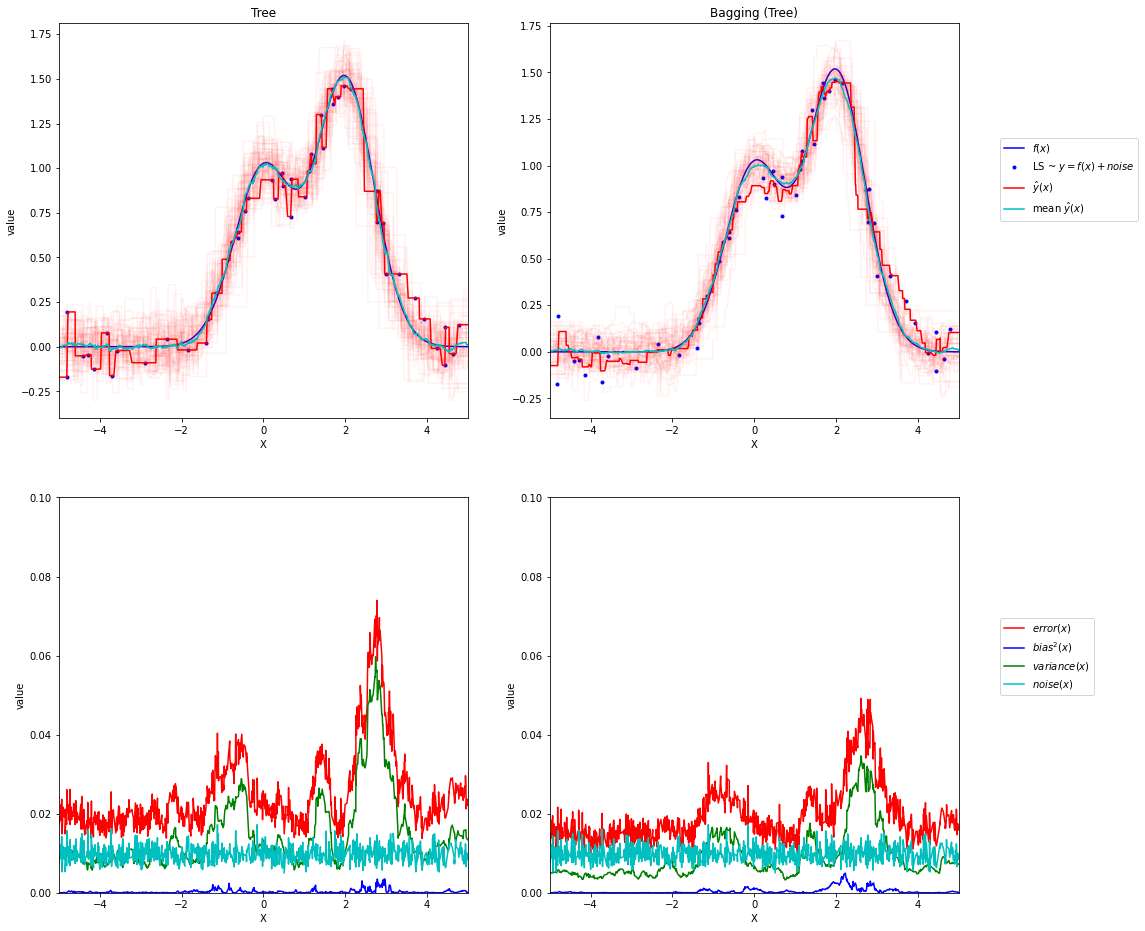

In [6]:
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging (Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

plt.figure(figsize=(20, 16))

for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")
    plt.xlabel('X')
    plt.ylabel('value')

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"mean $\^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")
    plt.xlabel('X')
    plt.ylabel('value')

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

**Задание 1 (0.5 балла)**. Аналогичным образом происследуйте bias-variance decomposition для метода ближайших соседей и линейной регрессии. У какого метода меньше смещение? У какого метода меньше разброс? Как вы думаете, почему так?

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

KMeans: 14.1282 (error) = 9.0685 (bias^2)  + 5.0474 (var) + 0.0098 (noise)
LinearRegression: 0.2330 (error) = 0.2140 (bias^2)  + 0.0078 (var) + 0.0098 (noise)


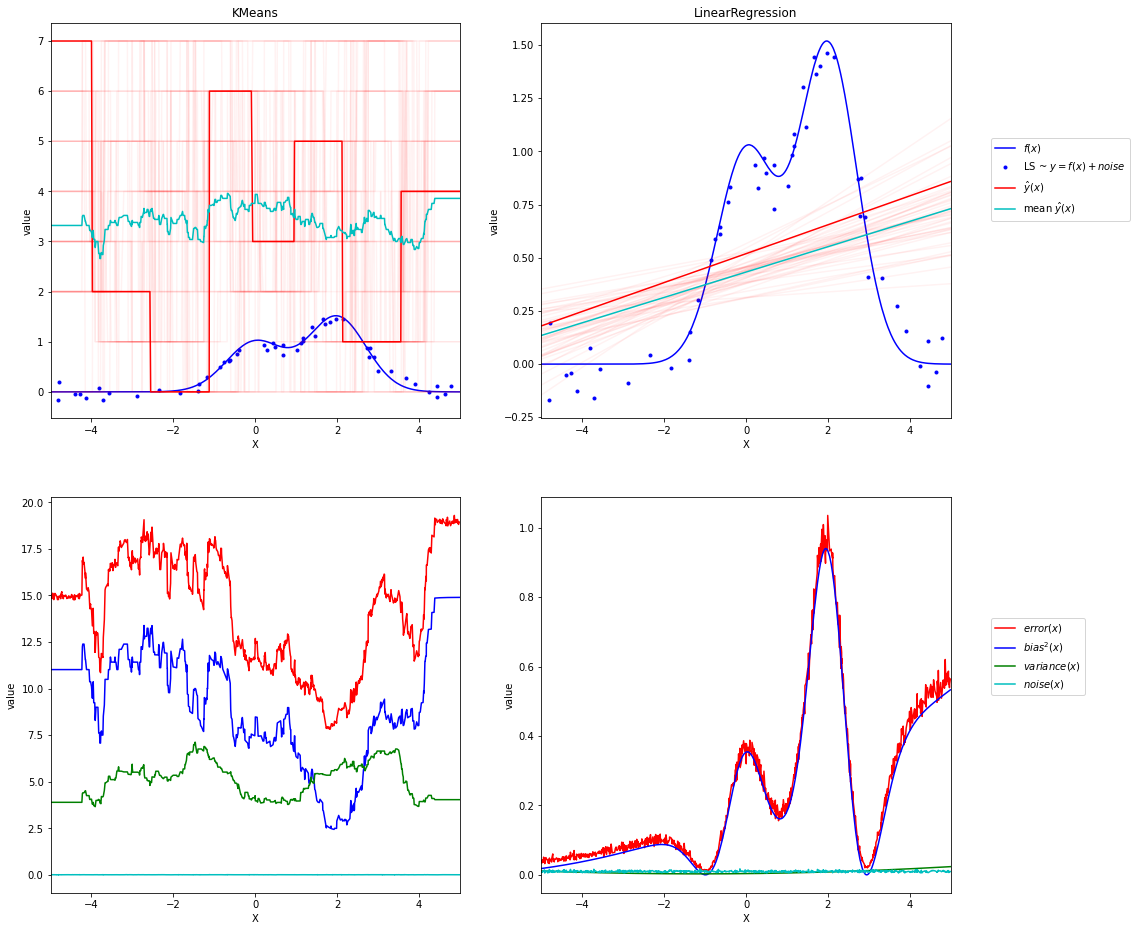

In [8]:
## YOUR CODE HERE

estimators = [("KMeans", KMeans()),
              ("LinearRegression", LinearRegression())]

n_estimators = len(estimators)

plt.figure(figsize=(20, 16))

for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")
    plt.xlabel('X')
    plt.ylabel('value')

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"mean $\^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")
    plt.xlabel('X')
    plt.ylabel('value')

    plt.xlim([-5, 5])
    # plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

YOUR ANSWER HERE

*У линейной регрессии смещение и разброс меньше*

**Задание 2 (0.5 балла)**. Аналогичным образом происследуйте зависимость разных компонент ошибок от параметра `max_depth` в дереве. Для этого на одной картинке нарисуйте несколько графиков значения bias от X. Аналогично поступите с variance. Выберите 5-10 показательных значений `max_depth`. Также постройте графики зависимости итоговых bias и variance от параметра `max_depth`. Проанализируйте полученные результаты. Как меняется bias и variance в зависимости от `max_depth` и почему?

LinearRegression: 0.0565 (error) = 0.0264 (bias^2)  + 0.0198 (var) + 0.0098 (noise)
LinearRegression: 0.0397 (error) = 0.0092 (bias^2)  + 0.0205 (var) + 0.0098 (noise)
LinearRegression: 0.0297 (error) = 0.0030 (bias^2)  + 0.0167 (var) + 0.0098 (noise)
LinearRegression: 0.0250 (error) = 0.0008 (bias^2)  + 0.0142 (var) + 0.0098 (noise)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

LinearRegression: 0.0246 (error) = 0.0004 (bias^2)  + 0.0142 (var) + 0.0098 (noise)


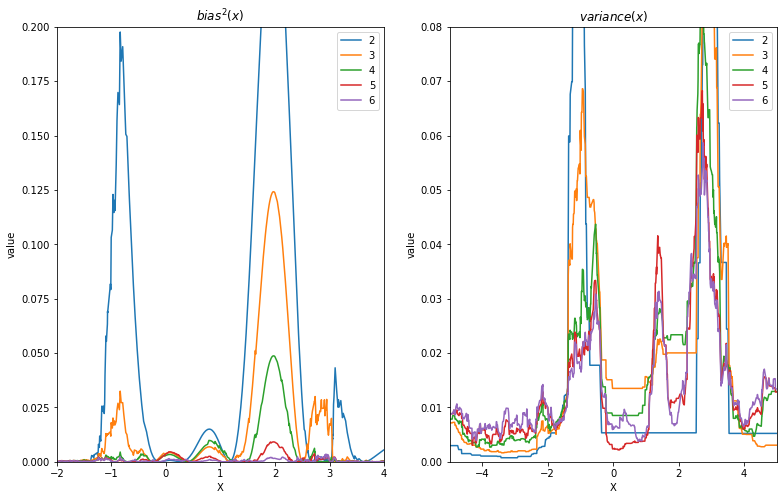

In [9]:
## YOUR CODE HERE

max_depths = [2, 3, 4, 5, 6]

n_estimators = len(estimators)

plt.figure(figsize=(16, 8))

for max_depth in max_depths:
    estimator = DecisionTreeRegressor(max_depth=max_depth)
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))
    plt.subplot(1, 2, 1)
    plt.title('$bias^2(x)$')
    plt.xlabel('X')
    plt.ylabel('value')
    plt.xlim([-2, 4])
    plt.ylim([0, 0.2])
    plt.plot(X_test, y_bias, label="$bias^2(x)$")

    if n == n_estimators - 1:
        plt.legend(max_depths)

    plt.subplot(1, 2, 2)
    plt.title("$variance(x)$")
    plt.xlabel('X')
    plt.ylabel('value')
    plt.xlim([-5, 5])
    plt.ylim([0, 0.08])
    plt.plot(X_test, y_var, label="$variance(x)$")
    
    if n == n_estimators - 1:
        plt.legend(max_depths)

plt.subplots_adjust(right=.75)
plt.show()

YOUR ANSWER HERE

*bias и var уменьшаются при увеличении max_depth*

## Extra Trees

Не только случайным лесом едины! Если случайности в случайном лесу вам недостаточно, ещё большая случайность используется в методе под названием Extra Trees. 

Проще всего различия между ними, обычными деревьями и случайным лесом показать в следующей табличке:
![](https://i.stack.imgur.com/Q18mk.png)

Каковы же преимущества Extra Trees перед Random Forest? Кажется, какие-то они слишком уж случайные :)

Оказывается, что преимущества два:
* Extra Trees работают значительно быстрее (что неудивительно, учитывая метод их построения)
* Extra Trees лучше ведут себя при наличии большого количества нерелевантных признаков

![](https://www.thekerneltrip.com/images/rf_vs_et.png)

Эксперименты, подтверждающие второй пункт, вам и предстоит повторить!

**Задание 3 (1 балл)**. Постройте график, аналогичный данному. Для этого:
* научитесь генерировать случайную выборку с линейной зависимостью от конечного и всегда одинакового числа признаков, при этом с возможностью нагенерировать сколько угодно шумных
* переберите количество признаков, для каждого количества несколько раз сгенерируйте такую случайную выборку
* на каждой такой выборке обучите [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) и [`ExtraTreesRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
* изобразите на графике их ошибку и стандартное отклонение

Предположите, почему же Extra Trees лучше работают при наличии лишних признаков, чем Random Forest?

In [10]:
## YOUR CODE HERE

YOUR ANSWER HERE

## Стекинг на практике

In [11]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

### Датасет

Наш сегодняшний датасет - это датасет бросков в игре дартс:

In [12]:
#!wget https://raw.githubusercontent.com/ben519/MLPB/master/Problems/Classify%20Dart%20Throwers/_Data/train.csv
train_df = pd.read_csv('https://raw.githubusercontent.com/ben519/MLPB/master/Problems/Classify%20Dart%20Throwers/_Data/train.csv')
train_df.head()

,ID,XCoord,YCoord,Competitor
0,111,0.943354,-0.184819,Bob
1,92,0.121557,-0.927656,Bob
2,20,0.818485,0.375437,Bob
3,75,0.867462,-0.159851,Sue
4,10,-0.817321,-0.373419,Kate


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


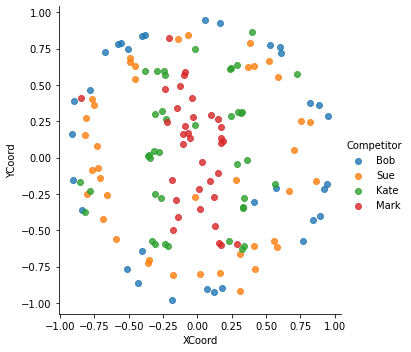

In [13]:
sns.lmplot('XCoord', 'YCoord', data=train_df, hue='Competitor', fit_reg=False)
plt.show()

In [14]:
#!wget https://raw.githubusercontent.com/ben519/MLPB/master/Problems/Classify%20Dart%20Throwers/_Data/test.csv
test_df = pd.read_csv('https://raw.githubusercontent.com/ben519/MLPB/master/Problems/Classify%20Dart%20Throwers/_Data/test.csv')
test_df.head()

,ID,XCoord,YCoord,Competitor
0,6,0.064729,0.356983,Mark
1,12,-0.766731,-0.255876,Sue
2,22,0.182282,-0.540976,Mark
3,34,-0.908910,0.223945,Bob
4,47,0.992230,-0.085550,Bob


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


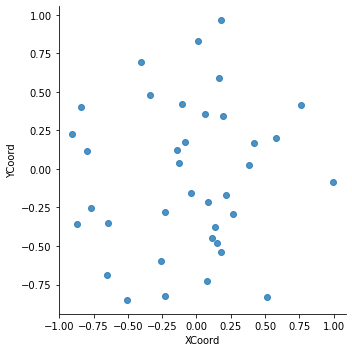

In [15]:
sns.lmplot('XCoord', 'YCoord', data=test_df, fit_reg=False)
plt.show()

Подготовим обучающую выборку в более привычном виде, а также подготовимся к визуализации разделяющей гиперплоскости:

In [16]:
X, y = train_df.values[:, 1:-1], train_df.values[:, -1:]

In [17]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [18]:
y_temp = []
for name in y:
    if name == 'Bob':
        y_temp.append(1)
    elif name == 'Mark':
        y_temp.append(2)
    elif name == 'Sue':
        y_temp.append(3)
    elif name == 'Kate':
        y_temp.append(4)
y = np.array(y_temp)

### Одиночные алгоритмы

Наш первый подопытный - kNN:

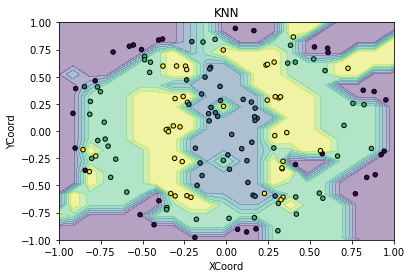

In [19]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('KNN')
plt.xlabel('XCoord')
plt.ylabel('YCoord')
plt.show()

А второй - SVM:

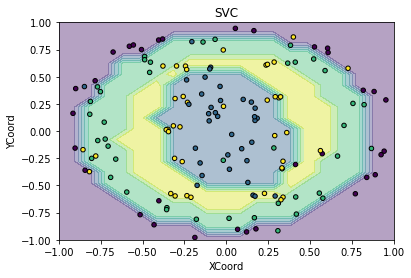

In [20]:
from sklearn.svm import SVC

clf = SVC(kernel='poly', degree=2)
clf.fit(X, y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('SVC')
plt.xlabel('XCoord')
plt.ylabel('YCoord')
plt.show()

Когда у нас есть два базовых классификатора (каждый из которых, как видно, справляется с классификацией очень по-разному), можно попытаться выжать из их комбинации всё :)

### Рецепт хорошего стекинга

Самый лучший рецепт - это выполненный своими руками! ;) Поэтому, слушайте внимательно:

**Задание 1 (1 балл)**.
* Подберите оптимальные параметры для двух базовых классификаторов. Посчитайте для них accuracy.
* Разбейте train на 5 фолдов.
* Для каждого фолда из train обучите классификатор на остальных и в качестве мета-фичи объектов этого фолда запишите предсказания моделей
* Обучите модель на всём train и для каждого объекта из test вычислите мета-фичи
* Возьмите новый классификатор и обучите его на train с мета-фичами
* Предскажите метки на test и измерьте accuracy

Бонус: у кого с помощью стекинга этих двух моделей получится наилучший результат на test, получит дополнительные 0.5 балла :)

In [21]:
# YOUR CODE HERE

Вопросы на засыпку:
* почему мета-фичи для объектов из train нужно получать так странно? Почему бы не обучиться на всём train и не сделать после этого предсказания?
* как правильно делать кросс-валидацию? Нормально ли использовать те же фолды, что и при обучении мета-фичей или нет?